In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind
# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings 
warnings.filterwarnings('ignore')

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.path.append('../')
from helpers import *

In [28]:
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

(None, None)

In [29]:
X_train = pd.read_csv("../training_data/X_train.csv")
X_test = pd.read_csv("../training_data/X_test.csv")
y_train = pd.read_csv("../training_data/y_train.csv")
y_test = pd.read_csv("../training_data/y_test.csv")

## Baseline Models

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import pandas as pd
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier

def evaluate_model(model, model_params, X_train, y_train, X_test, y_test):
    # Adjust model with provided parameters
    model.set_params(**model_params)
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    # Predictions
    y_pred = model.predict(X_test_imputed)
    y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Convert the classification report into a DataFrame
    metrics_df = pd.DataFrame(report).transpose()
    
    # Add accuracy and AUC to the DataFrame
    metrics_df.loc['Accuracy', 'precision'] = accuracy
    metrics_df.loc['AUC', 'precision'] = auc_score
    metrics_df.loc[['Accuracy', 'AUC'], ['recall', 'f1-score']] = np.nan  # Set non-applicable columns as NaN
    # Add the model name in the df
    metrics_df['model'] = model.__class__.__name__
    
    return metrics_df



In [31]:
# Correctly sampling the data
# X_train_sample = X_train.sample(50000, random_state=50)
# y_train_sample = y_train.loc[X_train_sample.index]  # Ensure the indices match

# X_test_sample = X_test.sample(50000, random_state=50)
# y_test_sample = y_test.loc[X_test_sample.index]  # Ensure the indices match


# import time
# start = time.time()
# xgb_params = {'tree_method': 'gpu_hist'}
# xgb_metrics_df = evaluate_model(XGBClassifier(random_state=50), xgb_params, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[XGB] Time taken in seconds: ", end - start)

# # RandomForestClassifier using 4 cores
# start = time.time()
# rf_params = {'n_jobs': 4}
# rf_metrics_df = evaluate_model(RandomForestClassifier(random_state=50), rf_params, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[RF] Time taken in seconds: ", end - start)

# LightGBM
# start = time.time()
# lgb_params = {'objective': 'binary', 'metric': 'auc', 'seed': 50, 'verbose': -1}
# lgb_metrics_df = evaluate_model(lgb.LGBMClassifier(), lgb_params, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[LGBM] Time taken in seconds: ", end - start)

# # CART (Decision Tree)
# start = time.time()
# cart_metrics_df = evaluate_model(DecisionTreeClassifier(random_state=50), {}, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[CART] Time taken in seconds: ", end - start)

# # Extra Trees
# start = time.time()
# et_metrics_df = evaluate_model(ExtraTreesClassifier(random_state=50), {}, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[ExtraTrees] Time taken in seconds: ", end - start)

# # CatBoost
# start = time.time()
# catboost_params = {
#     'task_type': 'GPU',
#     'devices': '0',  # Specifies the GPU ID to use. For multiple GPUs, use '0:1:2' for GPUs 0, 1, and 2, for example.
#     'random_seed': 50, 
#     'silent': True
# }

# # Evaluate CatBoost model
# catboost_metrics_df = evaluate_model(CatBoostClassifier(), catboost_params, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[CB] Time taken in seconds: ", end - start)

# #adaboost
# start = time.time()
# ada_metrics_df = evaluate_model(AdaBoostClassifier(random_state=50),{}, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[ADA] Time taken in seconds: ", end - start)

# #ID3
# start = time.time()
# dt_params = {'criterion': 'entropy', 'random_state': 50}
# id3_metrics_df = evaluate_model(DecisionTreeClassifier(), dt_params, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
# end = time.time()
# print("[ID3] Time taken in seconds: ", end - start)
# print(id3_metrics_df)

# xgb_metrics_df
# rf_metrics_df
# lgb_metrics_df
# catboost_metrics_df
# et_metrics_df
# cart_metrics_df
# ada_metrics_df
# id3_metrics_df

- [XGB] Time taken in seconds:  2.5977861881256104
- [RF] Time taken in seconds:  18.980974435806274
- [LGBM] Time taken in seconds:  3.175231456756592
- [CART] Time taken in seconds:  38.583603620529175
- [ExtraTrees] Time taken in seconds:  20.79372525215149
- [CB] Time taken in seconds:  12.561571836471558
- [ADA] Time taken in seconds:  60.43929672241211
- [ID3] Time taken in seconds:  18.666474103927612

#### Baseline models
<img src="../images/baseline1.png" alt="Alternative text" />
<img src="../images/baseline2.png" alt="Alternative text" />

#### GBDT vs DART vs GOSS

In [48]:
lgb_params = {'seed': 50, 'verbose': -1, 'boosting_type': 'gbdt', 'metric':'auc'}
lgb_params_dart = {'seed': 50, 'verbose': -1, 'boosting_type': 'dart', 'metric':'auc'}
lgb_params_goss = {'seed': 50, 'verbose': -1, 'boosting_type': 'goss', 'metric':'auc'}

# # LightGBM
# X_train_sample = X_train.sample(50000, random_state=50)
# y_train_sample = y_train.loc[X_train_sample.index]  # Ensure the indices match

# X_test_sample = X_test.sample(50000, random_state=50)
# y_test_sample = y_test.loc[X_test_sample.index]  # Ensure the indices match

# LightGBM with gbdt - Gradient Boosting Decision Tree
start = time.time()
lgb_metrics_df = evaluate_model(lgb.LGBMClassifier(), lgb_params, X_train, y_train, X_test, y_test)
end = time.time()
print("[LGBM-GBDT] Time taken in seconds: ", end - start)

# LGBM with dart - Dropouts meet Multiple Additive Regression Trees
start = time.time()
lgb_metrics_dart_df = evaluate_model(lgb.LGBMClassifier(), lgb_params_dart, X_train, y_train, X_test, y_test)
end = time.time()
print("[LGBM-DART] Time taken in seconds: ", end - start)

# LGBM with goss - Gradient-based One-Side Sampling
start = time.time()
lgb_metrics_goss_df = evaluate_model(lgb.LGBMClassifier(), lgb_params_goss, X_train, y_train, X_test, y_test)
end = time.time()
print("[LGBM-GOSS] Time taken in seconds: ", end - start)

[LGBM-GBDT] Time taken in seconds:  12.718122243881226
[LGBM-DART] Time taken in seconds:  15.026330471038818
[LGBM-GOSS] Time taken in seconds:  10.780333042144775


In [50]:
lgb_metrics_df
lgb_metrics_dart_df
lgb_metrics_goss_df

,precision,recall,f1-score,support,model
0,0.922523,0.997213,0.958415,70687.000000,LGBMClassifier
1,0.579060,0.043773,0.081394,6191.000000,LGBMClassifier
accuracy,0.920432,0.920432,0.920432,0.920432,LGBMClassifier
macro avg,0.750792,0.520493,0.519904,76878.000000,LGBMClassifier
weighted avg,0.894864,0.920432,0.887788,76878.000000,LGBMClassifier
Accuracy,0.920432,NaN,NaN,NaN,LGBMClassifier
AUC,0.781828,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.919494,1.000000,0.958059,70687.000000,LGBMClassifier
1,1.000000,0.000323,0.000646,6191.000000,LGBMClassifier
accuracy,0.919496,0.919496,0.919496,0.919496,LGBMClassifier
macro avg,0.959747,0.500162,0.479352,76878.000000,LGBMClassifier
weighted avg,0.925977,0.919496,0.880958,76878.000000,LGBMClassifier
Accuracy,0.919496,NaN,NaN,NaN,LGBMClassifier
AUC,0.762033,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.922371,0.997114,0.958287,70687.000000,LGBMClassifier
1,0.559395,0.041835,0.077848,6191.000000,LGBMClassifier
accuracy,0.920185,0.920185,0.920185,0.920185,LGBMClassifier
macro avg,0.740883,0.519474,0.518068,76878.000000,LGBMClassifier
weighted avg,0.893141,0.920185,0.887385,76878.000000,LGBMClassifier
Accuracy,0.920185,NaN,NaN,NaN,LGBMClassifier
AUC,0.777891,NaN,NaN,NaN,LGBMClassifier


### XGB fine-tuning

In [32]:
# from xgboost import XGBClassifier
# from skopt import BayesSearchCV
# from skopt.space import Real, Integer
# from skopt.callbacks import DeltaYStopper
# import time
# import matplotlib.pyplot as plt


# class IterationTrackingCallback:
#     def __init__(self):
#         self.start_time = time.time()
#         # Lists to store scores and parameter sets
#         self.best_scores = []
#         self.best_parameters = []
    
#     def __call__(self, res):
#         iteration_time = time.time() - self.start_time
#         print(f"\nIteration completed in {iteration_time:.2f} seconds.")
        
#         # Store the negated best score so far to correct its sign
#         best_score_so_far = -res.fun
#         self.best_scores.append(best_score_so_far)
#         print(f"Best score so far: {best_score_so_far:.4f}")

#         # Extract and store the best parameters so far
#         best_params_so_far = dict(zip(res.space.dimension_names, res.x))
#         self.best_parameters.append(best_params_so_far)
#         print("Best parameters so far:")
#         for param_name, param_value in best_params_so_far.items():
#             print(f"{param_name}: {param_value}")

#         self.start_time = time.time()



# # Initialize the callback
# iteration_callback = IterationTrackingCallback()

# # Define your XGBClassifier and BayesSearchCV as before
# model = XGBClassifier(tree_method='gpu_hist', random_state=42)

# search_spaces = {
#     'n_estimators': Integer(250, 300),
#     'max_depth': Integer(3, 6),
#     'learning_rate': Real(0.05, 0.2, 'log-uniform'),
#     'subsample': Real(0.85, 1.0),
#     'colsample_bytree': Real(0.7, 1.0),
#     'colsample_bylevel': Real(0.7, 1.0),  # Added based on your current range
#     'colsample_bynode': Real(0.7, 1.0),  # Added for experimentation
#     'min_child_weight': Integer(1, 3),
#     'gamma': Real(0, 5),
#     'reg_alpha': Real(1e-5, 1.0, 'log-uniform'),
#     'reg_lambda': Real(1e-5, 1.0, 'log-uniform'),
# }


# # Define your XGBClassifier and BayesSearchCV as before
# model = XGBClassifier(tree_method='gpu_hist', random_state=42)
# opt = BayesSearchCV(
#     estimator=model,
#     search_spaces=search_spaces,
#     n_iter=30,  # Reduced iterations for speed
#     scoring='roc_auc',
#     cv=5,
#     n_jobs=1,  # Keep as 1 for GPU usage
#     return_train_score=True,
#     refit=True,
#     random_state=42
# )
# # Fit BayesSearchCV with the callback
# opt.fit(X_train, y_train, callback=[iteration_callback])


# # Plotting the improvement of scores
# plt.figure(figsize=(10, 6))
# plt.plot(iteration_callback.best_scores, marker='o')
# plt.title('Improvement of Best AUC Score over Iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Best AUC Score')
# plt.grid(True)
# plt.show()



<img src="../images/XGB_AUC_scores.png" alt="Alternative text" />

**XGB Finetune**

**AUC: 0.7840**

- colsample_bylevel: 0.7
- colsample_bynode: 1.0
- colsample_bytree: 0.7
- gamma: 5.0
- learning_rate: 0.08807219785563987
- max_depth: 4
- min_child_weight: 3
- n_estimators: 300
- reg_alpha: 1e-05
- reg_lambda: 1.0
- subsample: 0.85

## LGBM Finetuning

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14907, number of negative: 169599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133578
[LightGBM] [Info] Number of data points in the train set: 184506, number of used features: 707
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

BayesSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=-1, random_state=42),
              n_iter=30, random_state=42, return_train_score=True,
              scoring='roc_auc',
              search_spaces={'colsample_bytree': Real(low=0.7, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.05, high=0.2, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=6, p...
                             'n_estimators': Integer(low=250, high=300, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=20, high=40, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-05, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-05, high=1.0, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.85, high=1.0, prior='uniform', transform='normalize')})

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Improvement of Best AUC Score over Iterations for LightGBM')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Best AUC Score')

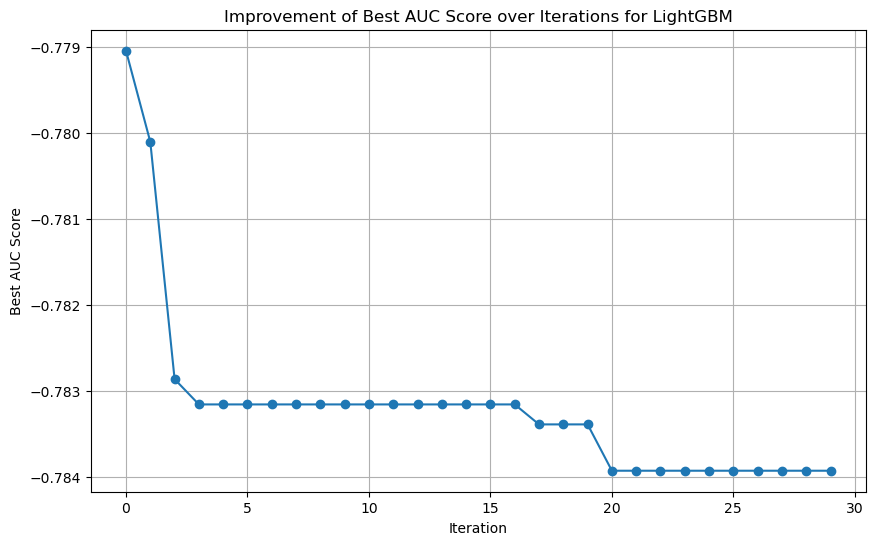

In [35]:
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeltaYStopper
import time
import matplotlib.pyplot as plt
import numpy as np

class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []
    
    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")
        
        best_score_so_far = res.fun  # Note: Depending on the scoring, you might need to negate this value
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()

# Assuming X_train and y_train are already defined

# Initialize the callback for LightGBM
iteration_callback_lgbm = IterationTrackingCallback()

# Define the LGBMClassifier
model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)  

# Define the search space for LightGBM
search_spaces_lgbm = {
    'colsample_bytree': Real(0.5, 0.7),  # Narrowed around 0.634
    'learning_rate': Real(0.005, 0.02, 'log-uniform'),  # Centered around 0.0101
    'max_depth': Integer(8, 12),  # Around 10
    'min_child_samples': Integer(200, 400),  # Centered around 300
    'min_child_weight': Integer(5, 15),  # Around 10
    'n_estimators': Integer(100, 200),  # Around 153
    'num_leaves': Integer(60, 90),  # Around 75
    'reg_alpha': Real(0.03, 0.1),  # Narrowed around 0.061
    'reg_lambda': Real(0.8, 1.2),  # Centered around 1.0
    'scale_pos_weight': Real(6, 10),  # Around 8.26
    'subsample': Real(0.7, 0.85),  # Narrowed around 0.783
    'subsample_freq': Integer(5, 15),  # Around 10
    'max_bin': Integer(350, 450),  # Centered around 400
}

# Set up BayesSearchCV for LightGBM
opt_lgbm = BayesSearchCV(
    estimator=model_lgbm,
    search_spaces=search_spaces_lgbm,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    n_jobs=1,
    return_train_score=True,
    refit=True,
    random_state=42
)

# Fit the model
opt_lgbm.fit(X_train, y_train, callback=[iteration_callback_lgbm])

# Plot the improvement of scores over iterations for LightGBM
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_lgbm.best_scores, marker='o')
plt.title('Improvement of Best AUC Score over Iterations for LightGBM')
plt.xlabel('Iteration')
plt.ylabel('Best AUC Score')
plt.grid(True)
plt.show()


<img src="../images/LGBM_AUC_scores.png" alt="Alternative text" />


**LGBM Best params**
- Best score so far: -0.7839
- Best parameters so far:
- colsample_bytree: 0.7777705221999338
- learning_rate: 0.05131099661915068
- max_depth: 6
- min_child_weight: 2
- n_estimators: 300
- num_leaves: 30
- reg_alpha: 0.020319134025071888
- reg_lambda: 0.006022332321095017
- subsample: 0.9654145490108178

### CATBoost Finetune


Iteration completed in 66.77 seconds.
Best score so far: -0.7835
Best parameters so far:
bootstrap_type: Bernoulli
border_count: 223
depth: 8
iterations: 395
l2_leaf_reg: 7.691035637882543
learning_rate: 0.07070593162427694
subsample: 0.8701862669798288

Iteration completed in 44.17 seconds.
Best score so far: -0.7835
Best parameters so far:
bootstrap_type: Bernoulli
border_count: 223
depth: 8
iterations: 395
l2_leaf_reg: 7.691035637882543
learning_rate: 0.07070593162427694
subsample: 0.8701862669798288

Iteration completed in 29.08 seconds.
Best score so far: -0.7835
Best parameters so far:
bootstrap_type: Bernoulli
border_count: 223
depth: 8
iterations: 395
l2_leaf_reg: 7.691035637882543
learning_rate: 0.07070593162427694
subsample: 0.8701862669798288

Iteration completed in 44.50 seconds.
Best score so far: -0.7835
Best parameters so far:
bootstrap_type: Bernoulli
border_count: 223
depth: 8
iterations: 395
l2_leaf_reg: 7.691035637882543
learning_rate: 0.07070593162427694
subsample:

BayesSearchCV(cv=5,
              estimator=<catboost.core.CatBoostClassifier object at 0x7f20ac264040>,
              n_iter=30, random_state=42, return_train_score=True,
              scoring='roc_auc',
              search_spaces={'bootstrap_type': Categorical(categories=('Bernoulli',), prior=None),
                             'border_count': Integer(low=150, high=250, prior='uniform', transform='normalize'),
                             'depth': Integer(low=4, high=8, prior='uniform', transform='normalize'),
                             'iterations': Integer(low=300, high=600, prior='uniform', transform='normalize'),
                             'l2_leaf_reg': Real(low=3, high=10, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.05, high=0.1, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.8, high=1.0, prior='uniform', transform='normalize')})

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Improvement of Best AUC Score over Iterations for CatBoost')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Best AUC Score')

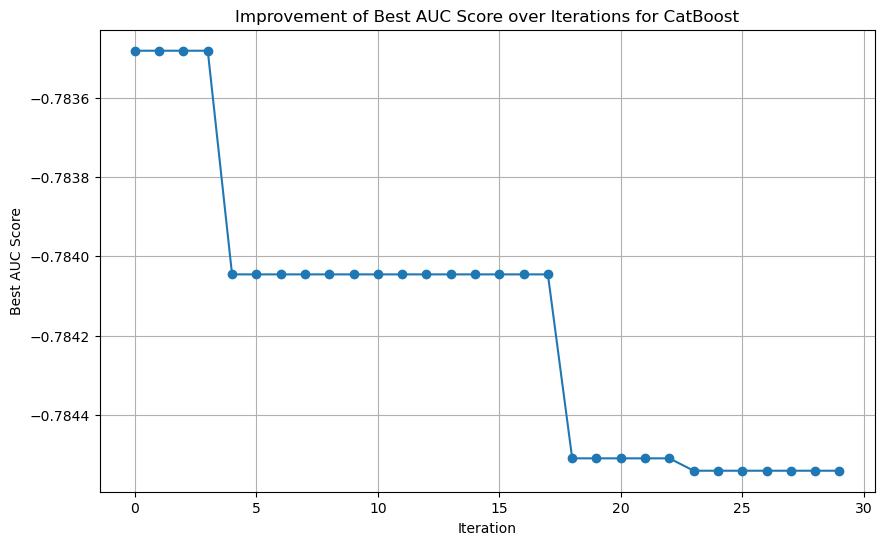

In [38]:
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import time
import matplotlib.pyplot as plt
import numpy as np

class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []
    
    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")
        
        best_score_so_far = res.fun  # Note: Depending on the scoring, you might need to negate this value
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Initialize the callback for CatBoost
iteration_callback_catboost = IterationTrackingCallback()

# Define the CatBoostClassifier
model_catboost = CatBoostClassifier(task_type="GPU", random_state=42, verbose=0)

# Define the search space for CatBoost
search_spaces_catboost = {
    'bootstrap_type': Categorical(['Bernoulli']),  # Based on your best parameters
    'border_count': Integer(150, 250),  # Around 209
    'depth': Integer(4, 8),  # Around 6
    'iterations': Integer(300, 600),  # Around 450
    'l2_leaf_reg': Real(3, 10),  # Around 6.33
    'learning_rate': Real(0.05, 0.1),  # Around 0.0756
    'subsample': Real(0.8, 1.0),  # Around 0.929
}

# Set up BayesSearchCV for CatBoost
opt_catboost = BayesSearchCV(
    estimator=model_catboost,
    search_spaces=search_spaces_catboost,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    n_jobs=1,
    return_train_score=True,
    refit=True,
    random_state=42
)

# Fit the model
opt_catboost.fit(X_train, y_train, callback=[iteration_callback_catboost])

# Plot the improvement of scores over iterations for CatBoost
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_catboost.best_scores, marker='o')
plt.title('Improvement of Best AUC Score over Iterations for CatBoost')
plt.xlabel('Iteration')
plt.ylabel('Best AUC Score')
plt.grid(True)
plt.show()


<img src="../images/CAT_AUC_scores.png" alt="Alternative text" />


**CATBOOST best params**
- Best score so far: 0.7845
- Best parameters so far:
- bootstrap_type: Bernoulli
- border_count: 192
- depth: 5
- iterations: 600
- l2_leaf_reg: 10.0
- learning_rate: 0.1
- subsample: 0.9933553655563268

### RF Finetune


Iteration completed in 122.15 seconds.
Best score so far: 0.7271
Best parameters so far:
max_depth: 11
max_features: log2
min_samples_leaf: 6
min_samples_split: 5
n_estimators: 368

Iteration completed in 208.85 seconds.
Best score so far: 0.7290
Best parameters so far:
max_depth: 18
max_features: log2
min_samples_leaf: 3
min_samples_split: 10
n_estimators: 446

Iteration completed in 67.62 seconds.
Best score so far: 0.7290
Best parameters so far:
max_depth: 18
max_features: log2
min_samples_leaf: 3
min_samples_split: 10
n_estimators: 446

Iteration completed in 372.39 seconds.
Best score so far: 0.7463
Best parameters so far:
max_depth: 17
max_features: sqrt
min_samples_leaf: 4
min_samples_split: 8
n_estimators: 309

Iteration completed in 564.55 seconds.
Best score so far: 0.7474
Best parameters so far:
max_depth: 17
max_features: sqrt
min_samples_leaf: 4
min_samples_split: 8
n_estimators: 462

Iteration completed in 183.95 seconds.
Best score so far: 0.7474
Best parameters so far:

BayesSearchCV(cv=5,
              estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
              n_iter=20, random_state=42, return_train_score=True,
              scoring='roc_auc',
              search_spaces={'max_depth': Integer(low=5, high=20, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=6, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize')})

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Improvement of Best AUC Score over Iterations for Random Forest')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Best AUC Score')

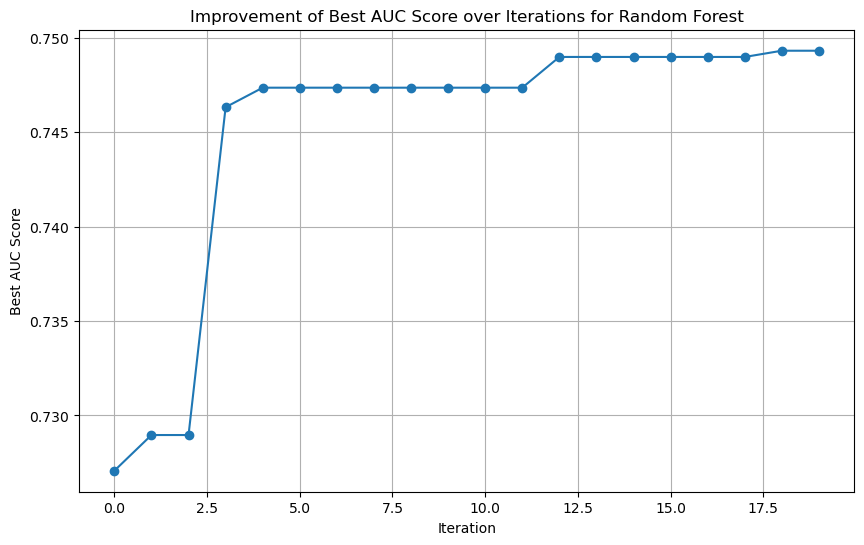

In [41]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import time
import matplotlib.pyplot as plt
import numpy as np

class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []
    
    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")
        
        best_score_so_far = -res.fun  # Assuming we are maximizing AUC
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()

# Initialize the callback for Random Forest
iteration_callback_rf = IterationTrackingCallback()

# Define the RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the search space for RandomForest
search_spaces_rf = {
    'n_estimators': Integer(100, 500),  # Number of trees
    'max_depth': Integer(5, 20),  # Depth of each tree
    'min_samples_split': Integer(2, 10),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': Integer(1, 6),  # Minimum number of samples required to be at a leaf node
    'max_features': Categorical(['sqrt', 'log2']),
}

# Set up BayesSearchCV for Random Forest
opt_rf = BayesSearchCV(
    estimator=model_rf,
    search_spaces=search_spaces_rf,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    n_jobs=1,  # Use -1 for all CPUs
    return_train_score=True,
    refit=True,
    random_state=42
)

# Fit the model
opt_rf.fit(X_train, y_train, callback=[iteration_callback_rf])

# Plot the improvement of scores over iterations for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_rf.best_scores, marker='o')
plt.title('Improvement of Best AUC Score over Iterations for Random Forest')
plt.xlabel('Iteration')
plt.ylabel('Best AUC Score')
plt.grid(True)
plt.show()


<img src="../images/RF_AUC_scores.png" alt="Alternative text" />


**RF Best Params** :
 0.7493
- Best parameters so far:
- max_depth: 14
- max_features: sqrt
- min_samples_leaf: 6
- min_samples_split: 2
- n_estimators: 500

## Blending Fine-tuned Models

In [45]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Define your fine-tuned models
models = [
    RandomForestClassifier(max_depth=13, max_features='sqrt', min_samples_leaf=6,
                           min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=42),
    LGBMClassifier(colsample_bytree=0.7777705221999338, learning_rate=0.05131099661915068,
                   max_depth=6, min_child_weight=2, n_estimators=300, num_leaves=30,
                   reg_alpha=0.020319134025071888, reg_lambda=0.006022332321095017,
                   subsample=0.9654145490108178, random_state=42, n_jobs=-1),
    CatBoostClassifier(bootstrap_type='Bernoulli', border_count=192, depth=5,
                       iterations=600, l2_leaf_reg=10.0, learning_rate=0.1,
                       subsample=0.9933553655563268, verbose=0, task_type='GPU', devices='0', random_state=42),
    XGBClassifier(colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
                  gamma=5, learning_rate=0.08807219785563987, max_depth=4,
                  min_child_weight=3, n_estimators=300, reg_alpha=1e-05,
                  reg_lambda=1.0, subsample=0.85, use_label_encoder=False, eval_metric='logloss', random_state=42, tree_method='gpu_hist')
]

# Assuming X_train and y_train are defined
X_blend_train, X_blend_test, y_blend_train, y_blend_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

n_models = len(models)
predictions = np.zeros((X_blend_test.shape[0], n_models))

for i, model in enumerate(models):
    print(model.__class__.__name__)
    # Randomly select half of the features for each model to train on
    random_features = np.random.choice(X_blend_train.columns, size=len(X_blend_train.columns) // 2, replace=False)
    
    # Train the model on these features
    model.fit(X_blend_train[random_features], y_blend_train)
    
    # Predict on the test set
    predictions[:, i] = model.predict_proba(X_blend_test[random_features])[:, 1]

# Average the predictions
final_blend_predictions = np.mean(predictions, axis=1)

# Evaluate (Example using AUC)
print(f"Blended Model AUC: {roc_auc_score(y_blend_test, final_blend_predictions)}")


RandomForestClassifier


RandomForestClassifier(max_depth=13, min_samples_leaf=6, n_estimators=500,
                       n_jobs=-1, random_state=42)

LGBMClassifier
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15030, number of negative: 169476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67223
[LightGBM] [Info] Number of data points in the train set: 184506, number of used features: 353
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081461 -> initscore=-2.422663
[LightGBM] [Info] Start training from score -2.422663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

LGBMClassifier(colsample_bytree=0.7777705221999338,
               learning_rate=0.05131099661915068, max_depth=6,
               min_child_weight=2, n_estimators=300, n_jobs=-1, num_leaves=30,
               random_state=42, reg_alpha=0.020319134025071888,
               reg_lambda=0.006022332321095017, subsample=0.9654145490108178)

CatBoostClassifier


XGBClassifier


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Blended Model AUC: 0.770769846222543


## Stacking Fine-tuned Models

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
oof_preds = np.zeros((X_train.shape[0], len(models)))

# Generate OOF predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, model in enumerate(models):
    print(f"Training and predicting with model {i+1}/{len(models)}...")
    for train_idx, valid_idx in kf.split(X_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model.fit(X_train_fold, y_train_fold)
        oof_preds[valid_idx, i] = model.predict_proba(X_valid_fold)[:, 1]

# Train the meta-model on the OOF predictions
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(oof_preds, y_train)




Training and predicting with model 1/4...


RandomForestClassifier(max_depth=13, min_samples_leaf=6, n_estimators=500,
                       n_jobs=-1, random_state=42)

RandomForestClassifier(max_depth=13, min_samples_leaf=6, n_estimators=500,
                       n_jobs=-1, random_state=42)

RandomForestClassifier(max_depth=13, min_samples_leaf=6, n_estimators=500,
                       n_jobs=-1, random_state=42)

RandomForestClassifier(max_depth=13, min_samples_leaf=6, n_estimators=500,
                       n_jobs=-1, random_state=42)

RandomForestClassifier(max_depth=13, min_samples_leaf=6, n_estimators=500,
                       n_jobs=-1, random_state=42)

Training and predicting with model 2/4...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15030, number of negative: 169476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133604
[LightGBM] [Info] Number of data points in the train set: 184506, number of used features: 707
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081461 -> initscore=-2.422663
[LightGBM] [Info] Start training from score -2.422663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

LGBMClassifier(colsample_bytree=0.7777705221999338,
               learning_rate=0.05131099661915068, max_depth=6,
               min_child_weight=2, n_estimators=300, n_jobs=-1, num_leaves=30,
               random_state=42, reg_alpha=0.020319134025071888,
               reg_lambda=0.006022332321095017, subsample=0.9654145490108178)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14850, number of negative: 169656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133593
[LightGBM] [Info] Number of data points in the train set: 184506, number of used features: 707
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080485 -> initscore=-2.435773
[LightGBM] [Info] Start training from score -2.435773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(colsample_bytree=0.7777705221999338,
               learning_rate=0.05131099661915068, max_depth=6,
               min_child_weight=2, n_estimators=300, n_jobs=-1, num_leaves=30,
               random_state=42, reg_alpha=0.020319134025071888,
               reg_lambda=0.006022332321095017, subsample=0.9654145490108178)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14790, number of negative: 169716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133558
[LightGBM] [Info] Number of data points in the train set: 184506, number of used features: 706
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080160 -> initscore=-2.440175
[LightGBM] [Info] Start training from score -2.440175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier(colsample_bytree=0.7777705221999338,
               learning_rate=0.05131099661915068, max_depth=6,
               min_child_weight=2, n_estimators=300, n_jobs=-1, num_leaves=30,
               random_state=42, reg_alpha=0.020319134025071888,
               reg_lambda=0.006022332321095017, subsample=0.9654145490108178)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14968, number of negative: 169539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133621
[LightGBM] [Info] Number of data points in the train set: 184507, number of used features: 707
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081124 -> initscore=-2.427168
[LightGBM] [Info] Start training from score -2.427168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier(colsample_bytree=0.7777705221999338,
               learning_rate=0.05131099661915068, max_depth=6,
               min_child_weight=2, n_estimators=300, n_jobs=-1, num_leaves=30,
               random_state=42, reg_alpha=0.020319134025071888,
               reg_lambda=0.006022332321095017, subsample=0.9654145490108178)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14898, number of negative: 169609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133598
[LightGBM] [Info] Number of data points in the train set: 184507, number of used features: 707
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080745 -> initscore=-2.432269
[LightGBM] [Info] Start training from score -2.432269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier(colsample_bytree=0.7777705221999338,
               learning_rate=0.05131099661915068, max_depth=6,
               min_child_weight=2, n_estimators=300, n_jobs=-1, num_leaves=30,
               random_state=42, reg_alpha=0.020319134025071888,
               reg_lambda=0.006022332321095017, subsample=0.9654145490108178)

Training and predicting with model 3/4...


Training and predicting with model 4/4...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

LogisticRegression(max_iter=1000)

In [53]:
# Initialize the matrix for test predictions
test_preds = np.zeros((X_test.shape[0], len(models)))

# Fill the matrix with predictions
for i, model in enumerate(models):
    test_preds[:, i] = model.predict_proba(X_test)[:, 1]
# Predict with the meta-model
final_predictions = meta_model.predict_proba(test_preds)[:, 1]

# Assuming y_test is available, evaluate the performance
# Replace 'roc_auc_score' with your metric of choice if applicable
from sklearn.metrics import roc_auc_score

print(f"Stacking Ensemble Test AUC: {roc_auc_score(y_test, final_predictions)}")

# create a classification report
from sklearn.metrics import classification_report
y_pred = meta_model.predict(test_preds)
print(classification_report(y_test, y_pred))


Stacking Ensemble Test AUC: 0.784961411222385
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     70687
           1       0.49      0.09      0.16      6191

    accuracy                           0.92     76878
   macro avg       0.71      0.54      0.56     76878
weighted avg       0.89      0.92      0.89     76878

